In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

In [3]:
import numpy as np
import torch
import fastai as fai
import fastai.vision as faiv
import fastai.callbacks as faic
import data.load

In [4]:
gpu_id = 3
num_cores = 4

In [5]:
faiv.torch.cuda.set_device(gpu_id)

In [6]:
nb_name = 'crap-critic-resnet'
path = faiv.Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/')
data_pth = path/'training/trainsets/'
model_pth = path/'models/critics/'

In [7]:
model_pth

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics')

## Data loading

In [8]:
# Image augmentations
tfms = faiv.get_transforms()

In [9]:
# Confirm data path
data_pth

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets')

In [10]:
# Create databunch
db = (faiv.ImageList.from_folder(data_pth)
      .filter_by_folder(['hr', 'pssr', 'bilinear', 'svd_30_40'])
      .split_by_rand_pct()
      .label_from_folder()
      .transform(size=512, resize_method=faiv.ResizeMethod.CROP)
      .databunch(num_workers=num_cores, bs=32)
      .normalize(faiv.imagenet_stats))

In [11]:
db.classes

['bilinear', 'hr', 'pssr', 'svd_30_40']

In [12]:
# Dataset sizes
len(db.train_ds), len(db.valid_ds)

(319991, 79997)

In [13]:
# Batch size and number of batches
db.batch_size, len(db.train_dl)

(32, 9999)

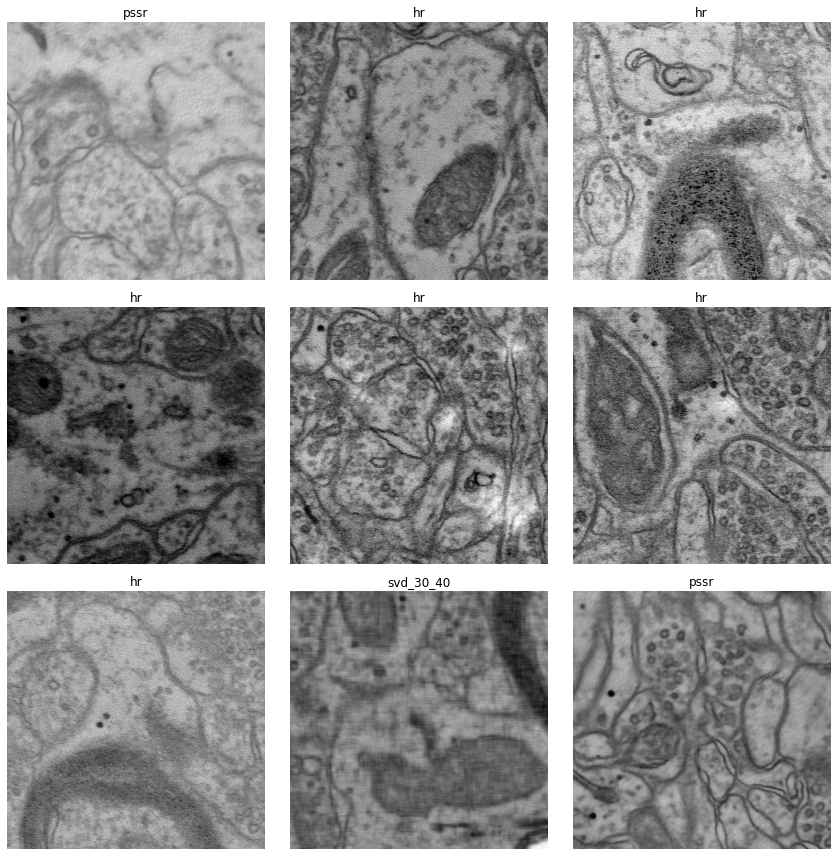

In [14]:
# Data Visualization
db.show_batch(rows=3)

# Model

## Initialization

In [15]:
learn = faiv.cnn_learner(db, faiv.models.resnet34, 
                         pretrained=False, metrics=faiv.error_rate)

In [16]:
learn.model_dir = model_pth

## Training

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


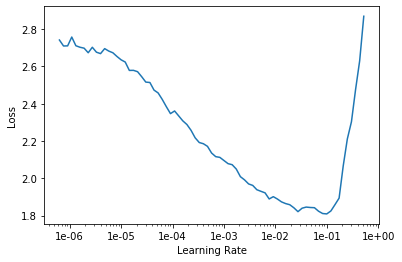

In [18]:
learn.recorder.plot()

In [19]:
lr = 1e-4
learn.fit_one_cycle(2, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.029727,0.021529,0.006375,1:15:54
1,0.003199,0.004399,0.000725,1:18:40


In [20]:
learn.save("full-stage-2a")

In [21]:
interp = faiv.ClassificationInterpretation.from_learner(learn)

In [36]:
faiv.doc(interp.plot_top_losses)

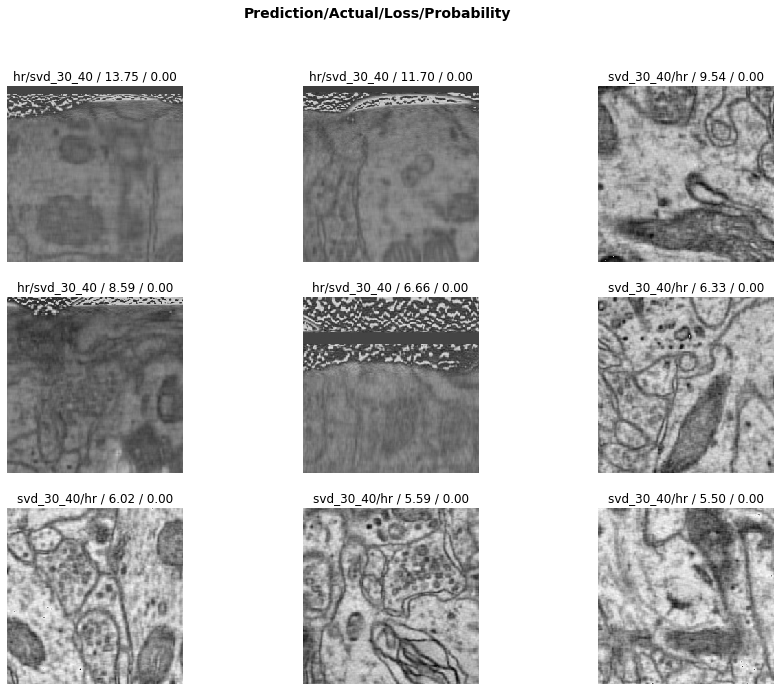

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

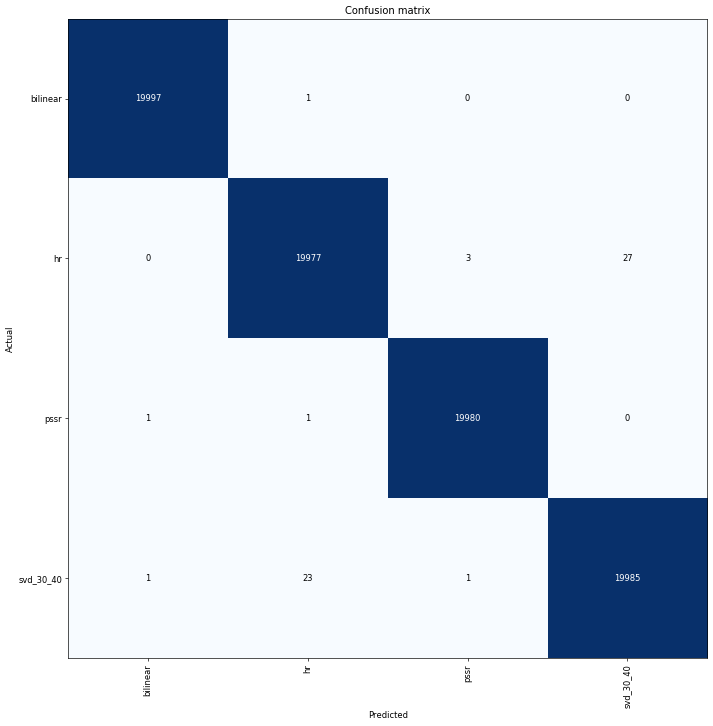

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
interp.most_confused(min_val=2)

[('pssr', 'hr', 12),
 ('bilinear', 'hr', 8),
 ('hr', 'svd_30_40', 5),
 ('svd_30_40', 'hr', 4)]

## Loading

In [17]:
learn.load("full-stage-2a");